In [26]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from astropy.io import fits
import pandas as pd
#Use the package that Amy used for determining weights
from lmfit import minimize, Parameters

Good, we shouldn't have a problem loading in each spectrum.

In [4]:
def plot_spec(wave, flux, errs, mask, Identifier):
    good_flux = (~np.isnan(flux) & ~np.isinf(flux))
    good_errs = (~np.isnan(errs) & ~np.isinf(errs))
    ylims1 = np.percentile(flux[good_flux],1)-0.2, np.percentile(flux[good_flux],99)+0.2
    ylims2 = np.percentile(errs[good_errs],1), np.percentile(errs[good_errs],99)
    
    fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(16,8), sharex=True, gridspec_kw={'height_ratios': [4, 1]})
    fig.subplots_adjust(hspace=0)
    ax1.plot(wave, flux, color="k", label="Final Co-added Spectrum", zorder=1)
    ax1.scatter(wave[mask==1], flux[mask==1], color="r", alpha=0.3, label="Masked Pixels - Coadd", zorder=2)
    #ax1.scatter(wave[mask==2], flux[mask==2], color="g", alpha=0.3, label="Masked Pixels - >4sig from Median", zorder=2)
    ax1.scatter(wave[mask>2], flux[mask>2], color="b", alpha=0.3, label="Masked Pixels - SDSS", zorder=2)
    ax2.plot(wave, errs, color="k", label="Final Co-added Errors", zorder=1)

    """
    ax1.plot([1549.48, 1549.48], [-100,100], "--r") #CIV
    ax1.text(1555, 0.9*ylims1[1], "CIV", color="red", fontsize=17.5)
    ax1.plot([1640.4, 1640.4], [-100,100], "--r") #CIV
    ax1.text(1641, 0.9*ylims1[1], "HeII?", color="red", fontsize=17.5) #these for UGC12163 mostly
    ax1.plot([1665.85, 1665.85], [-100,100], "--r") #CIV
    ax1.text(1666.5, 0.9*ylims1[1], "OIII?", color="red", fontsize=17.5)

    plt.plot([1908.73, 1908.73], [-100,100], "--r") #CIII]
    plt.text(1915, 0.9*ylims[1], "CIII]", color="red", fontsize=17.5)
    plt.plot([2799.1, 2799.1], [-100,100], "--r") #MgII
    plt.text(2785, 0.9*ylims[1], "MgII", color="red", fontsize=17.5)
    plt.plot([5000, 5000], [-100,100], "--r") #MgII
    plt.text(5005, 0.9*ylims[1], "HB+[OIII]", color="red", fontsize=17.5)
    plt.plot([6562.8, 6562.8], [-100,100], "--r") #MgII
    plt.text(6570, 0.9*ylims[1], "HA", color="red", fontsize=17.5)
    """
    ax1.set_xlim(min(wave)-2, max(wave)+2)
    ax1.set_ylim(ylims1)
    ax2.set_ylim(ylims2)
    ax1.set_xscale("log")
    ticks = np.array([1200,1500,1750,2000,2200,2500,3000,3500,4000,4500,5000,6000,7000,8000])
    ticks_use = ticks[(ticks>min(wave))&(ticks<max(wave))]
    ax2.set_xticks(ticks_use)
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.get_xaxis().set_tick_params(which='minor', size=0)
    ax2.get_xaxis().set_tick_params(which='minor', width=0)
    plt.minorticks_off()
    ax2.set_xlabel("Wavelength (Å)", fontsize=17.5)
    ax1.set_ylabel("Flux (Arbitrary units)", fontsize=17.5)
    ax2.set_ylabel("Error", fontsize=17.5)
    ax1.legend(loc=1)
    plt.suptitle(Identifier)
    plt.show()

In [7]:
!ls /Users/trevormccaffrey/Desktop/HST/AllData/SulenticAllData/Final_rebinned_tvm/

3C057_FOS_coadd_tvm.fits
3C095_FOS_coadd_tvm.fits
3C110_FOS_coadd_tvm.fits
3C207_FOS_coadd_tvm.fits
3C215_FOS_coadd_tvm.fits
3C232_FOS_coadd_tvm.fits
3C254_FOS_coadd_tvm.fits
3C263_FOS_coadd_tvm.fits
3C273_FOS_coadd_tvm.fits
3C281_FOS_coadd_tvm.fits
3C334_FOS_coadd_tvm.fits
3C336_FOS_coadd_tvm.fits
3C345_FOS_coadd_tvm.fits
3C390_FOS_coadd_tvm.fits
3C454_FOS_coadd_tvm.fits
Ark120_FOS_coadd_tvm.fits
B21425+26_STIS_coadd_tvm.fits
FBQS J074541.6+314256_FOS_coadd_tvm.fits
Fairall9_FOS_coadd_tvm.fits
HE0132-4313_FOS_coadd_tvm.fits
HS 0624+6907_FOS_coadd_tvm.fits
IRAS04505-2958_FOS_coadd_tvm.fits
J00392-5117_FOS_coadd_tvm.fits
J00449+1026_FOS_coadd_tvm.fits
J00535+1241_COS_coadd_tvm.fits
J00535+1241_FOS_coadd_tvm.fits
J01376-2430_STIS_coadd_tvm.fits
J02171+1104_FOS_coadd_tvm.fits
J04055-1308_FOS_coadd_tvm.fits
J04232-0120_FOS_coadd_tvm.fits
J04232-0120_STIS_coadd_tvm.fits
J04412-4313_FOS_coadd_tvm.fits
J04561-2159_FOS_coadd_tvm.fits
J05198-4546_FOS_coadd_tvm.fits
J06357-7516_FOS_coadd_tvm.fit

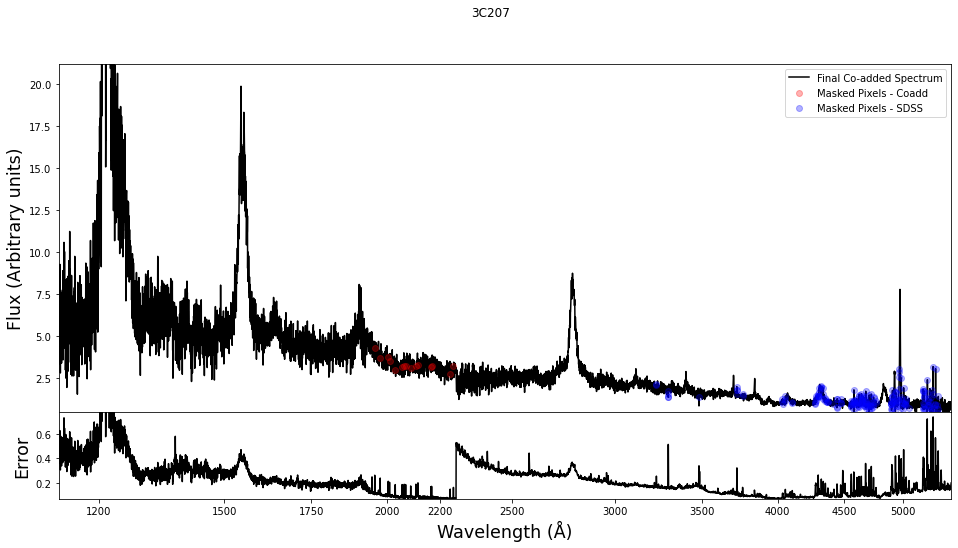

In [9]:
path = "/Users/trevormccaffrey/Desktop/HST/AllData/SulenticAllData/Final_rebinned_tvm/"
fn_spec = "3C207_FOS_coadd_tvm.fits"
spec = fits.open("%s%s"%(path,fn_spec))
wave = spec[1].data["Rest-frame Wavelength"]
flux = spec[1].data["Coadded Flux"]
errs = spec[1].data["Coadded Flux Errors"]
mask = spec[1].data["Bad Pixel Mask"]
plot_spec(wave, flux, errs, mask, "3C207")

---

In [16]:
wave[(wave>1260)&(wave<3000)].shape

(3768,)

In [12]:
#Load in ICA components and save in Dataframe
cmod = pd.read_csv("/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/ICAcomponents_amy/amy_12603000_10c_180421.comp", sep="\s+", 
                    names=["c1","c2","c3","c4","c5","c6","c7","c8","c9","c10"])
#Load in wave arrays for each set of components
wave_mod = pd.read_csv("/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/ICAcomponents_amy/wav_12603000.dat", names=["wave"])

In [17]:
cmod.shape

(3768, 10)

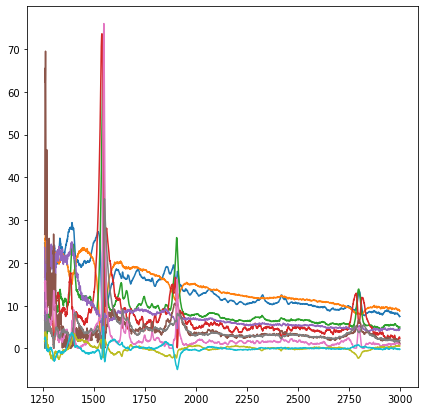

In [18]:
fig = plt.figure(figsize=(7,7))
for i in range(cmod.shape[1]):
    plt.plot(wave_mod, cmod.iloc[:,i])
plt.show()

In [21]:
cmod.iloc[:,0].values

array([24.698806 , 24.739279 , 24.224352 , ...,  7.4664656,  7.5596106,
        7.4918263])

In [39]:
components_mod = np.array([cmod.iloc[:,i].values for i in range(cmod.shape[1])])

In [40]:
def residual(params, comps, data, eps_data):
    model = sum(params[w].value*comps[n] for (n, w) in enumerate(params))
    return (data-model)**2 * eps_data

def ICA_fit(components, wave, spectrum, ivar):#, flags):
    params = Parameters()
    for i in range(len(components)):
        params.add('W%d' % (i+1), value=0)
    #MASK = mask(components, wave, spectrum, ivar, flags)
    return minimize(residual, params, args=(components, spectrum, ivar), method="lbfgsb", nan_policy='omit')

In [41]:
components_mod

array([[24.698806  , 24.739279  , 24.224352  , ...,  7.4664656 ,
         7.5596106 ,  7.4918263 ],
       [16.686412  , 16.817581  , 17.866104  , ...,  8.8096222 ,
         8.8598369 ,  8.7888494 ],
       [ 7.6885478 ,  7.5951971 ,  6.5884903 , ...,  4.7788739 ,
         4.8126608 ,  5.0121908 ],
       ...,
       [ 6.5386458 ,  6.5030973 ,  6.0130814 , ...,  1.8502634 ,
         1.9309066 ,  1.9145287 ],
       [ 1.6642592 ,  1.6886688 ,  2.0421065 , ...,  0.63786907,
         0.6148948 ,  0.57441343],
       [ 2.1834546 ,  2.1585216 ,  2.1822711 , ..., -0.22653016,
        -0.14258833, -0.16937064]])

In [44]:
ica_mask = (wave>1260)&(wave<3000)
fit_mod  = ICA_fit(components_mod, wave[ica_mask], flux[ica_mask], 1/(errs[ica_mask]**2))

In [45]:
fit_mod

In [46]:
fit_mod.params

name,value,initial value,min,max,vary
W1,-0.02638778,0,-inf,inf,True
W2,0.11017862,0,-inf,inf,True
W3,0.06620661,0,-inf,inf,True
W4,0.10259206,0,-inf,inf,True
W5,0.03558170,0,-inf,inf,True
W6,0.04809543,0,-inf,inf,True
W7,0.11413760,0,-inf,inf,True
W8,0.12646276,0,-inf,inf,True
W9,0.01788724,0,-inf,inf,True
W10,-0.10870872,0,-inf,inf,True


In [47]:
weights_mod = [fit_mod.params[i].value for i in fit_mod.params]

In [48]:
weights_mod

[-0.026387779931527664,
 0.11017861679677571,
 0.06620660967274662,
 0.10259205832222838,
 0.0355816971943462,
 0.04809543238190119,
 0.11413759793638956,
 0.1264627565352386,
 0.017887244084642595,
 -0.10870871857840297]

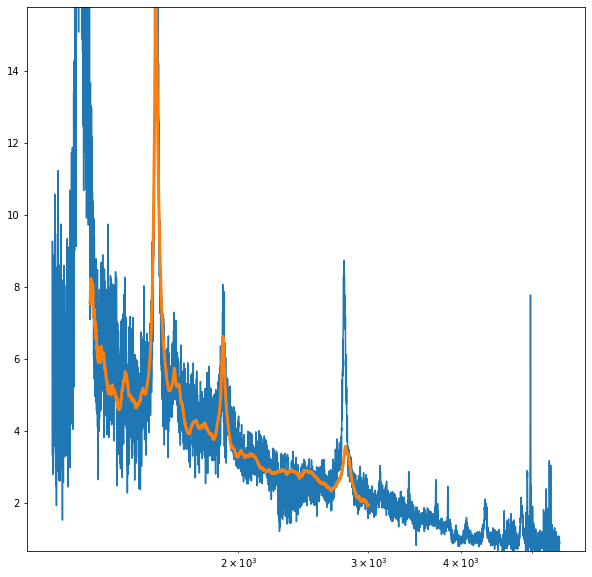

In [54]:
fig = plt.figure(figsize=(10,10))
plt.plot(wave, flux)
plt.plot(wave_mod, np.dot(weights_mod, components_mod), lw=3)
plt.ylim(np.percentile(flux, 1), max(np.dot(weights_mod, components_mod)))
plt.xscale("log")
plt.show()